In [ ]:
# Regression model in neural network is like linear regression in simple standalone model (target is continuous)
# Unlike scikit-learn, PyTorch doesn't come with built-in high-level models like "LogisticRegression" or "RandomForestClassifier". Instead, PyTorch provides building blocks that you use to construct these models yourself.

In [9]:
import pandas as pd

df = pd.read_csv('FuelConsumption.csv')
print(df.shape)
df.head()

(1067, 13)


,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

x_num = df[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY', 
           'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB', 
           'FUELCONSUMPTION_COMB_MPG']]
x_cat = df[['MODELYEAR', 'VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE']]

x_cat_encoded = pd.get_dummies(x_cat, drop_first=True)
x = pd.concat([x_num, x_cat_encoded], axis=1)
X = x.values
X = StandardScaler().fit_transform(X)  # standardize Xs: mean 0, std 1

y = df[['CO2EMISSIONS']].values  # [[]] so we don't need to do y = y.reshape(-1, 1) later in class FuelDataset

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # if there are few rows, we just create X_train and X_test
# temp: temporary. It's an intermediate dataset used to further split the data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to tensors
X_train = torch.FloatTensor(X_train)  # or we can write one code in class init later (self.X = torch.FloatTensor(X)) to do all Xs and one code to do all ys (but cause we need these later I think this way is better)    
X_val = torch.FloatTensor(X_val)    
X_test = torch.FloatTensor(X_test) 
y_train = torch.FloatTensor(y_train)    
y_val = torch.FloatTensor(y_val)    
y_test = torch.FloatTensor(y_test) 

In [11]:
# In practice, simple networks often use nn.Sequential, while more complex architectures (like ResNet) use separate layer definitions (nn.Linear) for more control.
# check other files for nn.Linear

In [12]:
# build, train, evaluate a neural network regression model with layers of
# Input layer to 64 neurons
# Hidden layer of 64 to 32 neurons
# Output layer of 32 to 1 neuron

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# convert initial data to useable data for PyTroch model (to create custom dataset check end of the page)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# create data loaders for 3 reasons:
# Batch processing - splits data into smaller batches for efficient training
# Shuffle data - randomizes order of samples
# Memory efficiency - loads data in batches instead of all at once
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # so we can get X_batch, y_batch in train_loader later
# we use shuffle=True just in train_loader. It helps prevent the model from learning the order of the data rather than the actual patterns
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)    


# create the model
class NeuralNRegressionModel(nn.Module):  # inherits from nn.Module class  
    def __init__(self, input_dim):  # input_dim (dimension): number of input features (columns)
        super().__init__()  # It's required in PyTorch models to properly set up the neural network inheritance chain and initialize all the necessary components from the parent class.
        self.layers = nn.Sequential(  # nn.Sequential: It's a container that can hold MULTIPLE layers (unlike nn.Linear that is single layer) in sequence. It lets you stack layers one after another, where output of one becomes input to next
            nn.Linear(input_dim, 64),  # input layer:  Linear layer transforming input_dim features to 64 neurons
            nn.ReLU(),  # Activation function that converts negative values to 0, keeps positive values unchanged
            nn.Linear(64, 32),  # hidden layer: Linear layer reducing 64 neurons to 32 neurons
            nn.ReLU(),
            nn.Linear(32, 1)  # output layer: Final layer converting 32 neurons to 1 output (prediction)
        )

    def forward(self, x):  # takes your input data x and passes it through all the layers that were defined in self.layers (which could be a sequence of multiple layers) in order, and returns the final output.
        return self.layers(x)


# Initialize model
model = NeuralNRegressionModel(input_dim=len(x.columns))
# input_dim: all predictor columns. note that we count encoded columns too
criterion = nn.MSELoss()  #  Creates Mean Squared Error loss function for training
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Creates Adam optimizer with learning rate 0.001 to update model parameters during training


train_losses = []  # Store training loss for each epoch
val_losses = []  # Store validation loss for each epoch
n_epochs = 100

# Training Loop for each epoch (An epoch is one complete pass through the entire training dataset):
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    for X_batch, y_batch in train_loader:  # Process each batch
        optimizer.zero_grad()  # Clear previous gradients
        train_pred = model(X_batch)  # forward padd: Make predictions
        #* Note that in PyTorch we don't train the model like Keras with X and y! We just use Xs, and the first train_pred is a random thing since we didn't tell anything about y to th model. Then in the next steps, it finds the weights and bias by loss and optimizer
        loss = criterion(train_pred, y_batch)  # Calculate loss for each batch
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        train_loss += loss.item()  # Accumulate batch loss

    train_loss = train_loss / len(train_loader)  # average loss among batches in this epoch  
    # len(train_loader): number of batches in your training dataset
    train_losses.append(train_loss)  # store it

    # we do the first evaluation here during the training process to validate performance after each epoch.
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Don't compute gradients during validation
        for X_batch, y_batch in val_loader:
            val_pred = model(X_batch)
            loss = criterion(val_pred, y_batch)
            val_loss += loss.item()

    val_loss = val_loss / len (val_loader)
    val_losses.append(val_loss)


    if (epoch + 1) % 10 == 0:  # print losses for each 10 epochs
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


# final evaluate the whole trained model on test set (not epoch-by-epoch)
model.eval()  # Set model to evaluation mode
test_predictions = []
test_actuals = []

with torch.no_grad():  # Disable gradient computation since we're only doing forward pass
    for X_batch, y_batch in test_loader:
        test_pred = model(X_batch)
        test_predictions.extend(test_pred.numpy())  # add test predictions to the list
        test_actuals.extend(y_batch.numpy())  # add actual test y values to the list

test_predictions = np.array(test_predictions)  # Convert lists of predictions to numpy array
test_actuals = np.array(test_actuals)

r2 = r2_score(test_actuals, test_predictions)
rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))


print(f"\nTest Results:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


Epoch [10/100], Train Loss: 8996.9825, Val Loss: 8408.1063
Epoch [20/100], Train Loss: 1417.9356, Val Loss: 1940.9887
Epoch [30/100], Train Loss: 657.7748, Val Loss: 995.1589
Epoch [40/100], Train Loss: 367.2017, Val Loss: 599.9038
Epoch [50/100], Train Loss: 217.4806, Val Loss: 363.1377
Epoch [60/100], Train Loss: 136.0851, Val Loss: 234.9531
Epoch [70/100], Train Loss: 90.6017, Val Loss: 163.9232
Epoch [80/100], Train Loss: 63.1411, Val Loss: 124.3856
Epoch [90/100], Train Loss: 48.3535, Val Loss: 100.6247
Epoch [100/100], Train Loss: 35.6488, Val Loss: 85.9338

Test Results:
R² Score: 0.9654
RMSE: 11.4441


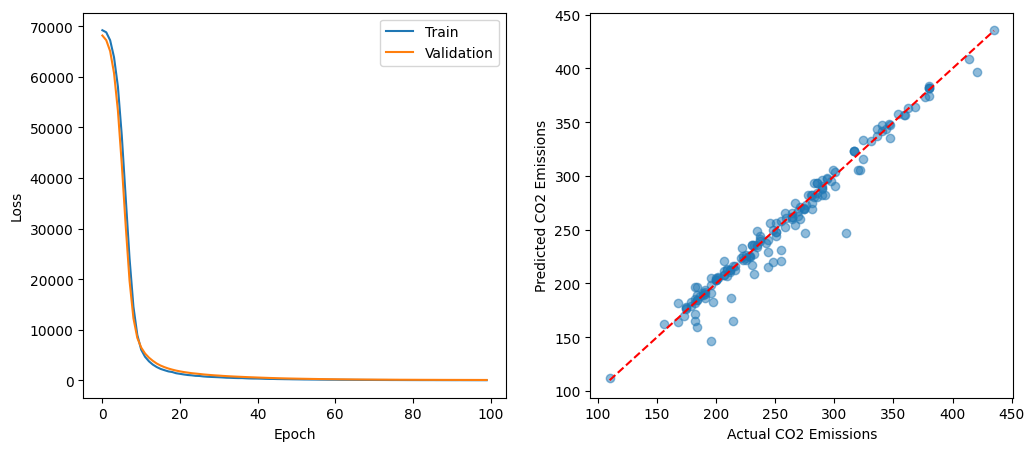

In [13]:
# plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # t(nrows, ncols, index)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(test_actuals, test_predictions, alpha=0.5)
plt.plot([min(test_actuals), max(test_actuals)], [min(test_actuals), max(test_actuals)], 'r--')
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.show()

In [14]:
'''
# create a custom dataset class as a converter of or data to useable data to use in our PyTorch model
class FuelDataset(Dataset):  # inherits from Dataset class  # Dataset class doesn't require super().init()
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)  # the number of rows (samples)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


'''

"\n# create a custom dataset class as a converter of or data to useable data to use in our PyTorch model\nclass FuelDataset(Dataset):  # inherits from Dataset class  # Dataset class doesn't require super().init()\n    def __init__(self, X, y):\n        self.X = X\n        self.y = y\n\n    def __len__(self):\n        return len(self.X)  # the number of rows (samples)\n\n    def __getitem__(self, idx):\n        return self.X[idx], self.y[idx]\n\n\n"